In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class CSCMatrix:
  def __init__(self,values,row_indices, col_ptr, shape):
    self.data = np.array(values)
    #row indices
    self.indices = np.array(row_indices)
    self.col_ptr = np.array(col_ptr)
    self.shape = shape

  @classmethod
  def from_dense(cls, data):
    rows, cols = len(data), len(data[0])
    vals = []
    row_indices = []
    col_ptr = [0]

    for i in range(cols):
      temp = 0
      for j in range(rows):
        if(data[j][i]!=0):
          vals.append(data[j][i])
          row_indices.append(j)
          temp = temp+1
      col_ptr.append(temp+col_ptr[-1])
    return cls(vals, row_indices, col_ptr, (rows, cols))

#inner product for CSC matrix


  def dot(self, vec):
    if len(vec) !=self.shape[1]:
      raise ValueError("The dimensions do not match")

    arr = [0]*self.shape[0]

    # loop throught the columns
    for i in range(self.shape[1]):
      start = self.col_ptr[i]
      end= self.col_ptr[i+1]
      #loop through the number of elements per column
      # this essentially represents the index of the rows
      for idx in range(start, end):
        #row indices
        row = self.indices[idx]
        arr[row]+=self.data[idx]*vec[i]

    return arr


  def matmat(self, matrix):

    if len(matrix)!=self.shape[1]:
      raise ValueError("The dimensions do not match")

    num_rows= len(matrix)
    num_cols = len(matrix[0])

    if num_rows==0 or num_cols==0:
      raise ValueError("The matrix cannot be empty")

    arr = np.zeros((self.shape[0], num_cols))

    for col in range(self.shape[1]):
      start = self.col_ptr[col]
      end= self.col_ptr[col+1]
      for i in range(start, end):
        row_ = self.indices[i]
        value= self.data[i]

        for k in range(num_cols):
          arr[row_,k]+=value*matrix[col][k]

    return arr




  def to_csr(self):
    nnz = len(self.data)
    num_rows = self.shape[0]
    num_cols = self.shape[1]

    # Count the number of nonzeros per row
    row_count = [0] * num_rows
    for i in range(nnz):
        row = self.indices[i]
        row_count[row] += 1

    # Build the row pointer for CSR
    csr_row_ptr = [0] * (num_rows + 1)
    for i in range(num_rows):
        csr_row_ptr[i + 1] = csr_row_ptr[i] + row_count[i]

    # Initialize arrays for CSR
    csr_data = [0] * nnz
    csr_col_indices = [0] * nnz

    # Temporary array to track current position for each row
    current_pos = csr_row_ptr[:]  # Copy of csr_row_ptr

    # Convert CSC to CSR
    for col in range(num_cols):
        start = self.col_ptr[col]
        end = self.col_ptr[col + 1]
        for idx in range(start, end):
            row = self.indices[idx]
            val = self.data[idx]

            # Place this element in the correct position for its row
            pos = current_pos[row]
            csr_data[pos] = val
            csr_col_indices[pos] = col
            current_pos[row] += 1

    return CSRMatrix(csr_data, csr_col_indices, csr_row_ptr, self.shape)




  def __getitem__(self, key):
    row, col = key
    # Check if row is within bounds
    if row < 0 or row >= self.shape[0]:
        raise IndexError(f"Row index {row} out of range")
    if col < 0 or col >= self.shape[1]:
        raise IndexError(f"Column index {col} out of range")

    # Get the start and end indices for the given row
    start = self.col_ptr[col]
    end = self.col_ptr[col+1]

    # Iterate over the non-zero elements in this row
    for idx in range(start, end):
        if self.indices[idx] == row:  # Check if column matches
            return self.data[idx]     # Return the value

    # If no non-zero element found at (row, col), return 0
    return 0


  def to_dense(self):
    dense = np.zeros(self.shape)
    for j in range(self.shape[1]):
      start, end =  self.col_ptr[j], self.col_ptr[j+1]
      for idx in range(start, end):
        i= self.indices[idx]
        dense[i, j] = self.data[idx]
    return dense




#CSR. MATRIX CLASS

class CSRMatrix:
    def __init__(self, values, col_indices, row_ptr, shape):
        self.data = np.array(values)
        self.indices = np.array(col_indices)
        self.index_ptr = np.array(row_ptr)
        self.shape = shape

    def diagonal(self):

      n = min(self.shape[0], self.shape[1])
      diag = np.zeros(n)

      for i in range(n):
        start = self.index_ptr[i]
        end = self.index_ptr[i+1]
        for j in range(start, end):
          if self.indices[j]==i:
            diag[i] = self.data[j]
            break
      return diag



    def __getitem__(self, key):
      row, col = key
    # Check if row is within bounds
      if row < 0 or row >= self.shape[0]:
          raise IndexError(f"Row index {row} out of range")
      if col < 0 or col >= self.shape[1]:
          raise IndexError(f"Column index {col} out of range")

    # Get the start and end indices for the given row
      start = self.index_ptr[row]
      end = self.index_ptr[row+1]

    # Iterate over the non-zero elements in this row
      for idx in range(start, end):
          if self.indices[idx] == col:  # Check if column matches
              return self.data[idx]     # Return the value

    # If no non-zero element found at (row, col), return 0
      return 0






  #allows us to construct a CSR object without using the __init__ constructor
    @classmethod
    def from_dense(cls, data):

      rows, cols = len(data), len(data[0])
      vals = []
      col_indices = []
      row_ptr = [0]

      for i in range(rows):
        temp = 0
        for j in range(cols):
          if(data[i][j]!=0):
            vals.append(data[i][j])
            col_indices.append(j)
            temp = temp+1
        row_ptr.append(temp+row_ptr[-1])

      return cls(vals, col_indices, row_ptr, (rows, cols))


    # allows us to multiply the matrix by vectors
    def dot(self, vec):

        #check that the columns of the matrix matches the rows of the vector

      if len(vec)!=self.shape[1]:
        raise ValueError("The dimensions do not match")

        #since the vector will be nx1
        #the matrix is mxn, therefore the result will be mx1, we only need the rows of the matrix
      ans = np.zeros(self.shape[0])

      for i in range(self.shape[0]):
        start = self.index_ptr[i]
        end = self.index_ptr[i+1]
        for j in range(start, end):
          ans[i]+=self.data[j]*vec[self.indices[j]]

      return ans


    def to_csc(self):
      if not hasattr(self, 'shape') or not hasattr(self, 'data') or not hasattr(self, 'indices')or not hasattr(self, 'index_ptr'):
          raise ValueError('Matrix is not in proper CSR format')

      nnz = len(self.data)
      num_rows = self.shape[0]
      num_cols = self.shape[1]

      #count the number of elements per column
      num_per_col = [0]*num_cols
      for i in range(nnz):
        num_per_col[self.indices[i]]+=1

      #build csc col_ptr
      csc_col_ptr=[0]*(num_cols+1)
      for i in range(num_cols):
        csc_col_ptr[i+1] = csc_col_ptr[i]+num_per_col[i]

      csc_data = [0]*nnz
      csc_row_index =[0]*nnz

      csc_temp = csc_col_ptr[:]

      for row in range(num_rows):
        start= self.index_ptr[row]
        end = self.index_ptr[row+1]
        for idx in range(start, end):
          col = self.indices[idx]
          value = self.data[idx]

          #place in correct column
          pos = csc_temp[col]
          csc_data[pos] = value
          csc_row_index[pos]= row
          csc_temp[col]+=1
      return CSCMatrix(csc_data, csc_row_index, csc_col_ptr, self.shape)


    #convert to dense matrix
    def to_dense(self):

      dense = np.zeros(self.shape)
      for i in range(self.shape[0]):
        start=self.index_ptr[i]
        end = self.index_ptr[i+1]
        for j in range(start, end):
          dense[i, self.indices[j]] =self.data[j]
      return dense


    #perform matrix by matrix multiplications
    def matmat(self, matrix):

      #input validation
      if not hasattr(matrix, 'shape') and not hasattr(matrix, '__len__'):
         raise TypeError("Input must be a matrix or 2d array")

      if hasattr(matrix, 'shape'):
         if len(matrix.shape)!=2:
            raise ValueError("input matrix must be 2-dimensional")
         if self.shape[1]!=matrix.shape[0]:
            raise ValueError(f"matrix dimensions incompatible: {self.shape[1]}!={matrix.shape[0]}")

         matrix_array = np.asarray(matrix)
         n_cols = matrix_array.shape[1]

      else:
         if not all(hasattr(row, '__len__') for row in matrix):
            raise ValueError("input must be a 2d matrix structure")

         n_rows = len(matrix)
         if n_rows==0:
            raise ValueError('input  matrix cannot be empty')
         n_cols  = len(matrix[0])
         if not all(len(row)==n_cols for row in matrix):
            raise ValueError("all rows in input matrix must have the same length")
         if self.shape[1]!=n_rows:
            raise ValueError(f'matrix dimensionss incompatible: {self.shape[1]}!=n_rows')

         matrix_array=np.array(matrix)

      result = np.zeros((self.shape[0], n_cols))


      #if the col len of our csr matrix is not matching the rows of the new matrix, cannot be done

      for i in range(self.shape[0]):
        start = self.index_ptr[i]
        end = self.index_ptr[i+1]
        for idx in range(start, end):
          j=self.indices[idx]
          value =self.data[idx]

          for k in range(len(matrix[0])):
            result[i,  k]+=value*matrix[j][k]

      return result


#COO Class

class COOMatrix:

  def __init__(self, data, row, col, shape):

    self.shape = shape
    self.data = np.array(data)
    self.row = np.array(row)
    self.col = np.array(col)


  @classmethod
  def from_dense(cls, data):
    #need to add error checking
    #number of rows, columns
    r, c = len(data), len(data[0])

    data_values = []
    cols = []
    rows = []

    for i in range(r):
      for j in range(c):
        if(data[i][j]!=0):
          data_values.append(data[i][j])
          cols.append(j)
          rows.append(i)

    return cls(data_values, rows, cols, (r, c))



  #convert into dense matrix
  def to_dense(self):

    #rows and cols
    row_len =self.shape[0]
    col_len = self.shape[1]

    arr = np.zeros((row_len, col_len))

    for i in range(len(self.data)):
      rows = self.row[i]
      cols = self.col[i]
      vals = self.data[i]
      arr[rows][cols] = vals
    return arr


  #convert into a CSR matrix

  def to_csr(self):
    nnz = len(self.data)
    num_rows, num_cols = self.shape

    # Step 1: count nonzeros per row
    csr_row_ptr = np.zeros(num_rows + 1, dtype=int)
    for r in self.row:
        csr_row_ptr[r + 1] += 1

    # Step 2: prefix sum
    for i in range(num_rows):
        csr_row_ptr[i + 1] += csr_row_ptr[i]

    # Step 3: allocate output arrays
    csr_data = np.zeros(nnz)
    csr_indices = np.zeros(nnz, dtype=int)

    # Step 4: scatter COO entries into CSR
    current_pos = csr_row_ptr.copy()
    for k in range(nnz):
        r = self.row[k]
        pos = current_pos[r]
        csr_data[pos] = self.data[k]
        csr_indices[pos] = self.col[k]
        current_pos[r] += 1

    return CSRMatrix(csr_data, csr_indices, csr_row_ptr, self.shape)



  #convert COO object into a CSC matrix
  def to_csc(self):
    dic_values = {(row, col): val for row, col, val in zip(self.row, self.col, self.data)}
    new_values = sorted(dic_values.items(), key=lambda x: (x[0][1], x[0][0]))

    rows = [item[0][0] for item in new_values]
    cols = [item[0][1] for item in new_values]
    data = [item[1] for item in new_values]

    # Get the number of columns from the maximum column index
    if cols:
        n_cols = max(cols) + 1
    else:
        n_cols = 0

    # Initialize col_ptr with zeros (size = n_cols + 1)
    col_ptr = np.zeros(n_cols + 1, dtype=int)

    # Count non-zero elements per column
    for col_idx in cols:
        col_ptr[col_idx + 1] += 1

    # Convert to cumulative sum
    col_ptr = np.cumsum(col_ptr)
    return CSCMatrix(data, rows, col_ptr, self.shape)









In [ ]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla
#baseline poisson equation
#applying to the  1d poisson equation
#-uxx(x) = f(x)
#x is in (0, 1)
#u(0) = u(1) = 0


#dictionary to hold residual information that we can plot
graph_residuals = {}
def poisson_1d_matrix(n):
#h = delta x (change in the space)


  h = 1/(n+1)

  data = []
  rows = []
  cols = []

  for i in range(n):
    #diagonal
    #left neighbor, right neighbor, diagonal

    data.append(2.0/h**2)
    rows.append(i)
    cols.append(i)

    #left neighbor
    if(i>0):
      data.append(-1.0/h**2)
      rows.append(i)
      cols.append(i-1)
    #right neighbor
    if(i<n-1):
      data.append(-1.0/h**2)
      rows.append(i)
      cols.append(i+1)

  return COOMatrix(data, rows, cols, (n, n))

#building the right hand side of the PDE
#

def build_rhs(n, f):
    #step size
    h = 1.0 / (n+1)
    #returns an array of evenly spaced numbers over a specified interval
    x = np.linspace(h,1-h, n)
    return np.array([f(xi) for xi in x])

#conjugate gradient code
#conjugate gradient applies here because the finite difference poisson operator
#produces a symmetric positive definite matrix
#therefore conjugate gradient converges in at most n iterations
#in exact arithmetic
def conjugate_gradient(A, b, tol, max_iter = 2000):
  """
  Conjugate Gradient iterative solve

  Parameters:
  A: matrix we are focused on
  b: right hand side vector
  tol: relative tolerance
  max_iter: maximum number of iterations

  Returns:
  x: solution
  residuals: List of residual norms



  """
  n = len(b)
  x = np.zeros(n)
  r= b-A.dot(x)
  p = r.copy()
  r_old = np.dot(r, r) #r^Tr
  residuals = [np.sqrt(r_old)]
  curr_iter = 0
  for i in range(max_iter):
    Ap = A.dot(p)
    #check for positive definiteness
    #positive definiteness is important here to ensure step length is not negative
    #and prevent possible risk of division by 0
    pAp = np.dot(p, Ap)
    assert pAp>0
    #step length
    alpha = r_old/np.dot(p, Ap)
    #approximate solution
    x+=alpha*p
    #residual
    r-=alpha*Ap
    #updating step length
    r_new = np.dot(r, r)
    #keeping track of the errors
    residuals.append(np.sqrt(r_new))
    if np.sqrt(r_new)/np.linalg.norm(b)<tol:
      #print(f"CG converged in {i+1} iterations")
      break

    beta = r_new/r_old
    #search direction
    p = r+beta*p
    r_old = r_new
    curr_iter = i+1

    #current residual = np.sqrt(r_new)
  info = {
      'iterations':curr_iter,
      'converged':(residuals[-1])/residuals[0]<tol,
      'initial_residual': residuals[0],
      'final_residual':residuals[-1],
      'residual_reduction': residuals[-1]/residuals[0],
      'max_iteration_reached':curr_iter==max_iter-1
      }

  return x, residuals, info



def get_true_solution(x, case_name):
    """Return the exact solution for various forcing functions."""
    if case_name == "sin(πx)":
        return np.sin(np.pi * x) / (np.pi**2)
    elif case_name == "sin(2πx)":
        return np.sin(2*np.pi * x) / (4*np.pi**2)
    elif case_name == "sin(3πx)":
        return np.sin(3*np.pi * x) / (9*np.pi**2)
    elif case_name == "x(1-x)":
        return -x**3/6 + x**4/12 + x/12
    elif case_name == "exp(x)":
        return -np.exp(x) + (np.e - 1)*x + 1
    else:
        raise ValueError(f"Unknown case: {case_name}")


def test():

  n = 1000

# Build Poisson matrix
  A_coo = poisson_1d_matrix(n)
  A_csr = A_coo.to_csr()


  test_cases = {
    "sin(πx)": (lambda x: np.sin(np.pi*x), 1),
    "sin(2πx)": (lambda x: np.sin(2*np.pi*x), 2),
    "sin(3πx)": (lambda x: np.sin(3*np.pi*x), 3),
    "x(1-x)": (lambda x: x*(1-x), None),
    "exp(x)": (lambda x: np.exp(x), None)
  }

  all_results = []
  print(f"\n=== 1D poisson - CG Solver Results ===\n")

  for name, (f_func, _ ) in test_cases.items():

    b = build_rhs(n, f_func)

    tol_lim = 0.01*(1/(n+1))**2
    u_cg, residuals, cg_info = conjugate_gradient(A_csr, b, tol_lim)

    x = np.linspace(1/n, 1-(1/(1+n)), n)
    u_exact = get_true_solution(x, name)

    graph_residuals[name] = residuals
# Computing the errors
    errors = {
        'inf':np.max(np.abs(u_cg-u_exact)),
        'l2':np.linalg.norm(u_cg - u_exact)/np.sqrt(n)
    }

    A_scipy = sp.csr_matrix((A_csr.data, A_csr.indices, A_csr.index_ptr), shape = A_coo.shape)
    u_scipy,scipy_info= spla.cg(A_scipy, b, atol=1e-12)
    scipy_diff = np.max(np.abs(u_cg-u_scipy))
    match = "✓" if scipy_diff < 1e-10 else "✗"
    print(f"{name:10s} iterations:{cg_info['iterations']:5d} errors: {errors['inf']:8.2e}  {match}")
    all_results.append({
        'name':name,
        'our_iterations':cg_info['iterations'],
        'scipy_iterations':scipy_info if isinstance(scipy_info, int) else -1,
        'error_inf':errors['inf'],
        'scipy_diff':scipy_diff,
        'converged':cg_info['converged']
    })


  print(f"Summary:")
  print(f"Average iterations:{np.mean([r['our_iterations'] for r in all_results]):.1f}")
  print(f"Max error: {max([r['error_inf'] for r in all_results]):.2e}")
  perfect_matches = sum(1 for r in all_results if r['scipy_diff']<1e-10)
  print(f"Perfect Scipy matches: {perfect_matches}/{len(all_results)}")
  print(2*"\n")





if __name__ =="__main__":
  test()







=== 1D poisson - CG Solver Results ===

sin(πx)    iterations:    0 errors: 3.18e-07  ✓
sin(2πx)   iterations:    0 errors: 1.58e-07  ✓
sin(3πx)   iterations:    0 errors: 1.15e-07  ✓
x(1-x)     iterations:  499 errors: 8.32e-08  ✓
exp(x)     iterations:  999 errors: 7.17e-07  ✓
Summary:
Average iterations:299.6
Max error: 7.17e-07
Perfect Scipy matches: 5/5





In [ ]:
"""
1. as we can see the sin functions are composed of eigenvectors of the poisson equation which is why we are seeing quick convergence
2. We see a slight correlation between the number of iterations and a decrease in the error
more iterations => less error
"""

'\n1. as we can see the sin functions are composed of eigenvectors of the poisson equation which is why we are seeing quick convergence\n2. We see a slight correlation between the number of iterations and a decrease in the error\nmore iterations => less error\n'

In [ ]:
"""
How should error scale = (1/grid_size)^accuracy
Since sin(k*pi*x) are eigenvectors of the function
they converge in minimal amount of iterations
We will be looking at how the residual changes based on the grid size

"""



grid_size = [50, 100, 200,400]
iterations_x1x = [] #we save the iteration information for the function x(1-x)
iterations_exp = [] # we save the informaiton for exp(x)

# keep track of the difference between the numerical and the exact solution
error_x1x = []
error_exp = []
#store the full residual history
residuals_x1x = []
residuals_exp = []

for size in grid_size:
  h = 1/(size+1)
  x = np.linspace(h, 1-h, size)
  right_hand_side ={
  "x(1-x)": (lambda x: x*(1-x), None),
  "exp(x)": (lambda x: np.exp(x), None)
  }
  true_solutions = {
    "x(1-x)":-x**3/6 + x**4/12 + x/12,
    "exp(x)":-np.exp(x) + (np.e - 1)*x + 1
}
  for func_name, (func_value, _) in right_hand_side.items():
    A = poisson_1d_matrix(size).to_csr()
    b = build_rhs(size, func_value)
    tol_lim = 0.01*h**2
    u_cg,residuals,info = conjugate_gradient(A, b, tol_lim)
    if func_name=="x(1-x)":
      iterations_x1x.append(info['iterations'])
      u_exact = true_solutions["x(1-x)"]
      error_x1x.append(np.max(np.abs(u_cg-u_exact)))
      residuals_x1x.append(residuals)
    else:
      iterations_exp.append(info['iterations'])
      u_exact = true_solutions["exp(x)"]
      error_exp.append(np.max(np.abs(u_cg-u_exact)))
      residuals_exp.append(residuals)



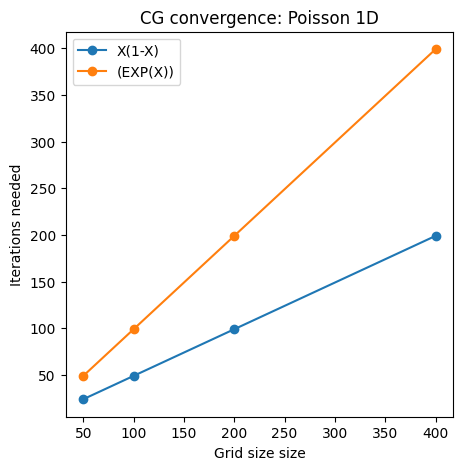

In [ ]:

#iterations vs grid size
plt.figure(figsize = (5,5))
plt.plot(grid_size, iterations_x1x, 'o-', label = f"X(1-X)")
plt.plot(grid_size, iterations_exp, 'o-', label = f"(EXP(X))")
plt.title("CG convergence: Poisson 1D")
plt.xlabel('Grid size size')
plt.ylabel('Iterations needed')
plt.legend()
plt.show()



In [ ]:
#As the number of iterations is increasing about the same rate as the size of the grids are increasing

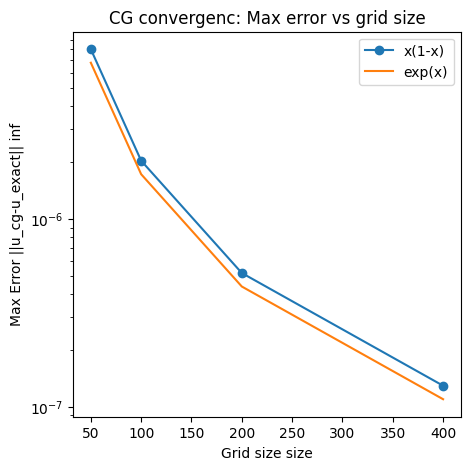

In [ ]:
#error vs grid size
plt.figure(figsize = (5,5))
plt.plot(grid_size, error_x1x, 'o-', label = "x(1-x)")
plt.plot(grid_size, error_exp, label = "exp(x)")
plt.title("CG convergenc: Max error vs grid size")
plt.xlabel('Grid size size')
plt.ylabel('Max Error ||u_cg-u_exact|| inf')
plt.yscale('log')
plt.legend()
plt.show()




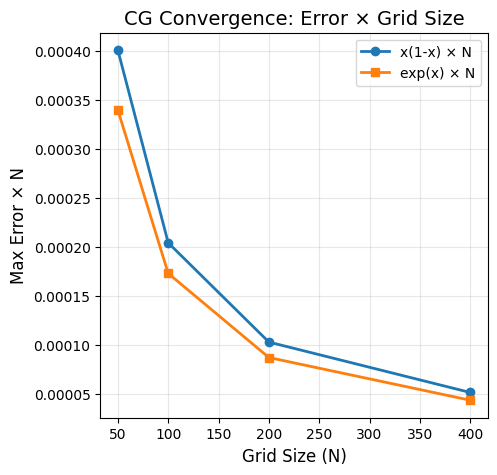

In [ ]:
# How does error change as we refine the grid
plt.figure(figsize=(5, 5))

# Normalize by grid size to see scaling
error_x1x_normalized = np.array(error_x1x) * np.array(grid_size)
error_exp_normalized = np.array(error_exp) * np.array(grid_size)

plt.plot(grid_size, error_x1x_normalized, 'o-', label='x(1-x) × N', linewidth=2)
plt.plot(grid_size, error_exp_normalized, 's-', label='exp(x) × N', linewidth=2)

plt.title('CG Convergence: Error × Grid Size', fontsize=14)
plt.xlabel('Grid Size (N)', fontsize=12)
plt.ylabel('Max Error × N', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




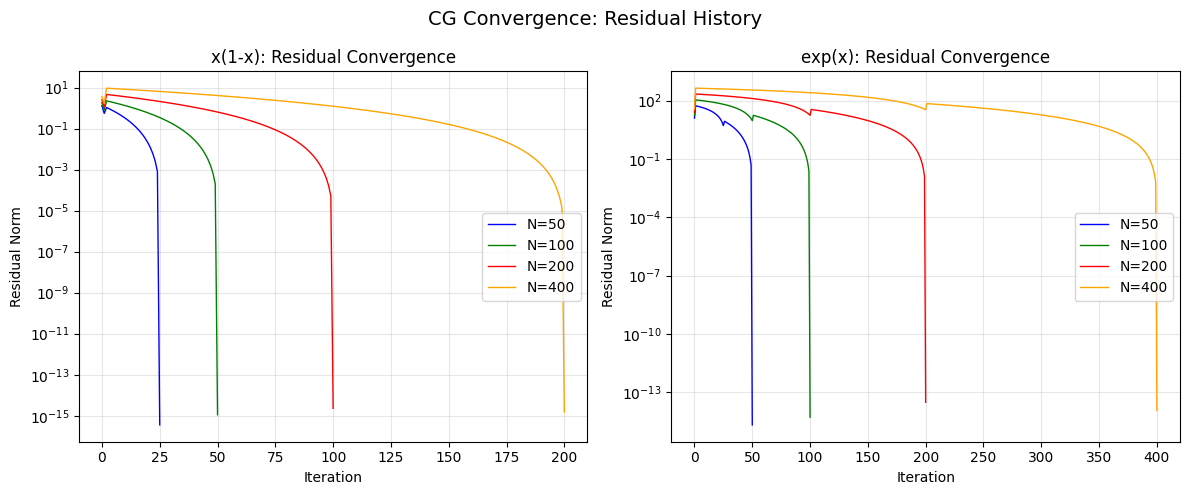

In [ ]:
# ============ FIGURE 3: Residual Convergence (first grid size) ============
plt.figure(figsize=(12, 5))

# Plot for x(1-x)
plt.subplot(1, 2, 1)
plt.semilogy(residuals_x1x[0], 'b-', linewidth=1, label=f'N={grid_size[0]}')
plt.semilogy(residuals_x1x[1], 'g-', linewidth=1, label=f'N={grid_size[1]}')
plt.semilogy(residuals_x1x[2], 'r-', linewidth=1, label=f'N={grid_size[2]}')
plt.semilogy(residuals_x1x[3], 'orange', linewidth=1, label=f'N={grid_size[3]}')
plt.title('x(1-x): Residual Convergence', fontsize=12)
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('Residual Norm', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for exp(x)
plt.subplot(1, 2, 2)
plt.semilogy(residuals_exp[0], 'b-', linewidth=1, label=f'N={grid_size[0]}')
plt.semilogy(residuals_exp[1], 'g-', linewidth=1, label=f'N={grid_size[1]}')
plt.semilogy(residuals_exp[2], 'r-', linewidth=1, label=f'N={grid_size[2]}')
plt.semilogy(residuals_exp[3], 'orange', linewidth=1, label=f'N={grid_size[3]}')
plt.title('exp(x): Residual Convergence', fontsize=12)
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('Residual Norm', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('CG Convergence: Residual History', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============ ORDER OF ACCURACY CALCULATION ============
print("\n" + "="*50)
print("ORDER OF ACCURACY")
print("="*50)
print(f"{'N':<10} {'Error x(1-x)':<20} {'Ratio':<15} {'Observed p':<15}")
print("-"*60)

prev_error = None
for i, n in enumerate(grid_size):
    error = error_x1x[i]
    if prev_error:
        ratio = prev_error / error
        p = np.log(ratio) / np.log(2)  # since grid doubles
        print(f"{n:<10} {error:<20.2e} {ratio:<15.2f} {p:<15.2f}")
    else:
        print(f"{n:<10} {error:<20.2e} {'-':<15} {'-':<15}")
    prev_error = error


ORDER OF ACCURACY
N          Error x(1-x)         Ratio           Observed p     
------------------------------------------------------------
50         8.01e-06             -               -              
100        2.04e-06             3.92            1.97           
200        5.16e-07             3.96            1.99           
400        1.30e-07             3.98            1.99           


In [ ]:
'''
introducing Pre-Conditioning
Jacobi Pre-conditioning
Original system Ax = b
M = diag(A)

'''

#preconditioned conjugate gradient
def pcg(A, b, tol, max_iter = 1000000):
  #the preconditioner M
  assert np.all(A.diagonal()!=0)
  M = 1/A.diagonal()
  n = len(b)
  x = np.zeros(n)
  r = b-A.dot(x)
  #solving for z in terms of Mz = r
  z = M*r
  p = z.copy()
  r_old = np.dot(r, z) #r^Tr
  residuals = [np.sqrt(r_old)]
  for i in range(max_iter):
    Ap = A.dot(p)
    #check for positive definiteness
    #positive definiteness is important here to ensure step length is not negative
    #and prevent possible risk of division by 0
    pAp = np.dot(p, Ap)
    assert pAp>0
    #step length
    alpha = r_old/np.dot(p, Ap)
    #approximate solution
    x+=alpha*p
    #residual
    r-=alpha*Ap
    z = M*r
    #updating step length
    r_new = np.dot(r, z)
    #keeping track of the errors
    residuals.append(np.sqrt(r_new))
    if np.sqrt(r_new)/np.linalg.norm(b)<tol:
      #print(f"converged in {i+1} iterations")
      break
    beta = r_new/r_old
    #search direction
    p = z+beta*p
    r_old = r_new
  return x, residuals, i+1









In [ ]:

grid_size = [50, 100, 200,400]
iterations_x1x = [] #we save the iteration information for the function x(1-x)
iterations_exp = [] # we save the informaiton for exp(x)

# keep track of the difference between the numerical and the exact solution
error_x1x = []
error_exp = []
#store the full residual history
residuals_x1x = []
residuals_exp = []

for size in grid_size:
  h = 1/(size+1)
  x = np.linspace(h, 1-h, size)

  right_hand_side ={
  "x(1-x)": (lambda x: x*(1-x)),
  "exp(x)": (lambda x: np.exp(x))
  }
  true_solutions = {
    "x(1-x)":-x**3/6 + x**4/12 + x/12,
    "exp(x)":-np.exp(x) + (np.e - 1)*x + 1
}

#creating the poisson matrix
  A = poisson_1d_matrix(size).to_csr()

  for func_name, func_value in right_hand_side.items():
    b = build_rhs(size, func_value)
    tol_aim = 0.01*h**2

    u_pcg, residuals_pcg,iterations = pcg(A, b,tol_aim)

    u_exact = true_solutions[func_name]
    max_error = np.max(np.abs(u_pcg-u_exact))

    if func_name=="x(1-x)":
      iterations_x1x.append(info['iterations'])
      error_x1x.append(max_error)
      residuals_x1x.append(residuals)
    else:
      iterations_exp.append(info['iterations'])
      error_exp.append(max_error)
      residuals_exp.append(residuals)

    print(f"  {func_name}: Iterations: {iterations}, Max error: {max_error:.2e}")

  x(1-x): Iterations: 25, Max error: 8.01e-06
  exp(x): Iterations: 50, Max error: 6.79e-06
  x(1-x): Iterations: 49, Max error: 2.04e-06
  exp(x): Iterations: 100, Max error: 1.73e-06
  x(1-x): Iterations: 98, Max error: 5.17e-07
  exp(x): Iterations: 200, Max error: 4.37e-07
  x(1-x): Iterations: 197, Max error: 1.30e-07
  exp(x): Iterations: 400, Max error: 1.10e-07


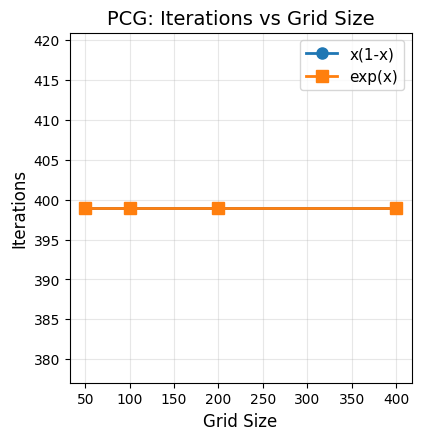

In [ ]:
plt.figure(figsize=(15, 10))

# Iterations vs grid size
plt.subplot(2, 3, 1)
plt.plot(grid_size, iterations_x1x, 'o-', label='x(1-x)', linewidth=2, markersize=8)
plt.plot(grid_size, iterations_exp, 's-', label='exp(x)', linewidth=2, markersize=8)
plt.xlabel('Grid Size', fontsize=12)
plt.ylabel('Iterations', fontsize=12)
plt.title('PCG: Iterations vs Grid Size', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

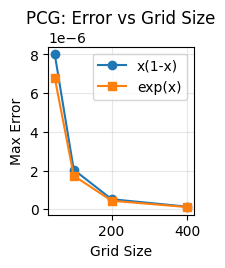

In [ ]:
#error vs grid size for the preconditioned matrix
plt.subplot(2, 3, 2)
plt.plot(grid_size, error_x1x, 'o-', label='x(1-x)')
plt.plot(grid_size, error_exp, 's-', label='exp(x)')
plt.xlabel('Grid Size')
plt.ylabel('Max Error')
plt.title('PCG: Error vs Grid Size')
plt.legend()
plt.grid(True, alpha=0.3)

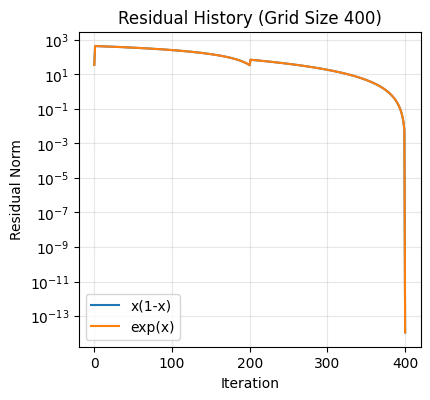

In [ ]:
plt.figure(figsize=(15, 9))
plt.subplot(2, 3, 3)
plt.semilogy(residuals_x1x[-1], label='x(1-x)')
plt.semilogy(residuals_exp[-1], label='exp(x)')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title(f'Residual History (Grid Size {grid_size[-1]})')
plt.legend()
plt.grid(True, alpha=0.3)

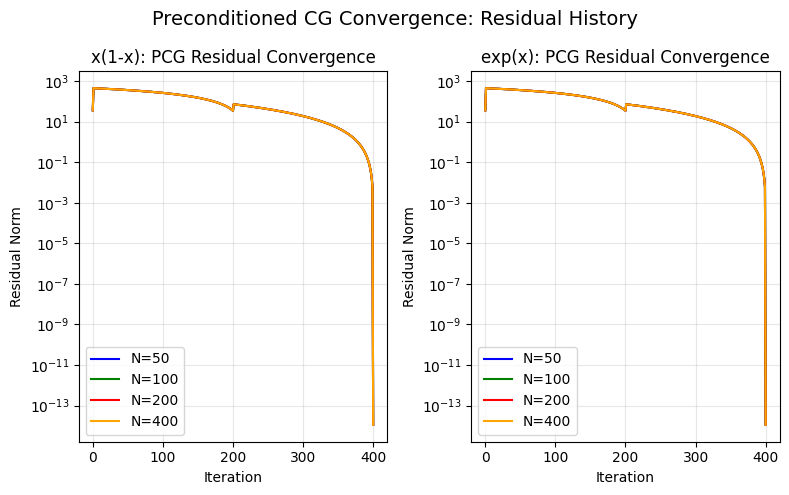

In [ ]:
# ============ FIGURE 3: Residual Convergence (all grid sizes) ============
plt.figure(figsize=(8, 5))

# Check if we have data
if len(residuals_x1x) > 0 and len(residuals_exp) > 0:

    # Plot for x(1-x)
    plt.subplot(1, 2, 1)
    colors = ['blue', 'green', 'red', 'orange']
    for i in range(min(len(residuals_x1x), len(grid_size))):
        plt.semilogy(residuals_x1x[i], color=colors[i % len(colors)],
                    linewidth=1.5, label=f'N={grid_size[i]}')

    plt.title('x(1-x): PCG Residual Convergence', fontsize=12)
    plt.xlabel('Iteration', fontsize=10)
    plt.ylabel('Residual Norm', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot for exp(x)
    plt.subplot(1, 2, 2)
    for i in range(min(len(residuals_exp), len(grid_size))):
        plt.semilogy(residuals_exp[i], color=colors[i % len(colors)],
                    linewidth=1.5, label=f'N={grid_size[i]}')

    plt.title('exp(x): PCG Residual Convergence', fontsize=12)
    plt.xlabel('Iteration', fontsize=10)
    plt.ylabel('Residual Norm', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Preconditioned CG Convergence: Residual History', fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("No residual data available to plot")

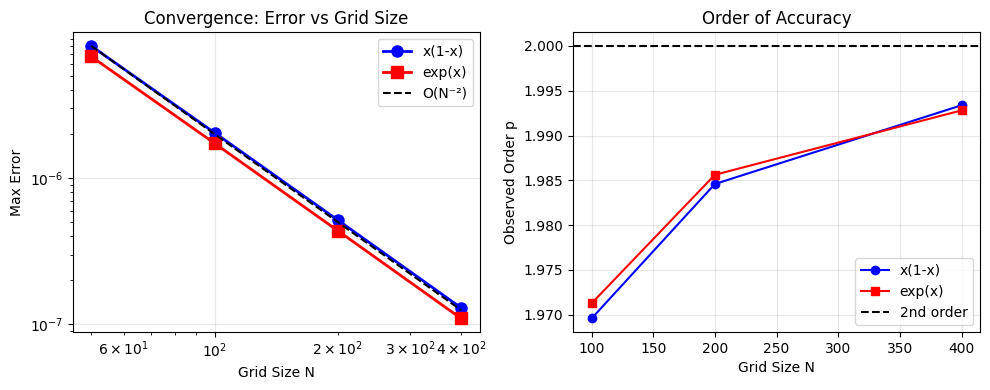

In [ ]:
# Plot convergence
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.loglog(grid_size, error_x1x, 'bo-', linewidth=2, markersize=8, label='x(1-x)')
plt.loglog(grid_size, error_exp, 'rs-', linewidth=2, markersize=8, label='exp(x)')
# Add reference line for 2nd order
ref_N = np.array([50, 400])
ref_error = error_x1x[0] * (ref_N[0]/ref_N)**2
plt.loglog(ref_N, ref_error, 'k--', label='O(N⁻²)')
plt.xlabel('Grid Size N')
plt.ylabel('Max Error')
plt.title('Convergence: Error vs Grid Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot observed order
orders_x1x = []
orders_exp = []
for i in range(1, len(grid_size)):
    orders_x1x.append(np.log(error_x1x[i-1]/error_x1x[i])/np.log(2))
    orders_exp.append(np.log(error_exp[i-1]/error_exp[i])/np.log(2))

plt.plot(grid_size[1:], orders_x1x, 'bo-', label='x(1-x)')
plt.plot(grid_size[1:], orders_exp, 'rs-', label='exp(x)')
plt.axhline(y=2, color='k', linestyle='--', label='2nd order')
plt.xlabel('Grid Size N')
plt.ylabel('Observed Order p')
plt.title('Order of Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============ ORDER OF ACCURACY CALCULATION ============
print("\n" + "="*60)
print("ORDER OF ACCURACY ANALYSIS")
print("="*60)

print("\nx(1-x) Function:")
print(f"{'N':<10} {'Error':<20} {'Ratio':<15} {'Observed p':<15}")
print("-"*60)

prev_error = None
for i, n in enumerate(grid_size):
    error = error_x1x[i]
    if prev_error:
        ratio = prev_error / error
        p = np.log(ratio) / np.log(2)
        print(f"{n:<10} {error:<20.2e} {ratio:<15.2f} {p:<15.2f}")
    else:
        print(f"{n:<10} {error:<20.2e} {'-':<15} {'-':<15}")
    prev_error = error

print("\nexp(x) Function:")
print(f"{'N':<10} {'Error':<20} {'Ratio':<15} {'Observed p':<15}")
print("-"*60)

prev_error = None
for i, n in enumerate(grid_size):
    error = error_exp[i]
    if prev_error:
        ratio = prev_error / error
        p = np.log(ratio) / np.log(2)
        print(f"{n:<10} {error:<20.2e} {ratio:<15.2f} {p:<15.2f}")
    else:
        print(f"{n:<10} {error:<20.2e} {'-':<15} {'-':<15}")
    prev_error = error

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
avg_p_x1x = np.mean([np.log(error_x1x[i]/error_x1x[i+1])/np.log(2) for i in range(len(grid_size)-1)])
avg_p_exp = np.mean([np.log(error_exp[i]/error_exp[i+1])/np.log(2) for i in range(len(grid_size)-1)])
print(f"Average observed order for x(1-x): {avg_p_x1x:.2f}")
print(f"Average observed order for exp(x): {avg_p_exp:.2f}")
print(f"Theoretical order: 2.00 (second-order accuracy)")


ORDER OF ACCURACY ANALYSIS

x(1-x) Function:
N          Error                Ratio           Observed p     
------------------------------------------------------------
50         8.01e-06             -               -              
100        2.04e-06             3.92            1.97           
200        5.17e-07             3.96            1.98           
400        1.30e-07             3.98            1.99           

exp(x) Function:
N          Error                Ratio           Observed p     
------------------------------------------------------------
50         6.79e-06             -               -              
100        1.73e-06             3.92            1.97           
200        4.37e-07             3.96            1.99           
400        1.10e-07             3.98            1.99           

SUMMARY
Average observed order for x(1-x): 1.98
Average observed order for exp(x): 1.98
Theoretical order: 2.00 (second-order accuracy)



Grid Size: 50

x(1-x):
  CG  - Iterations:   24, Max error: 8.01e-06
  PCG - Iterations:   25, Max error: 8.01e-06
  Speedup: 0.96x

exp(x):
  CG  - Iterations:   49, Max error: 6.79e-06
  PCG - Iterations:   50, Max error: 6.79e-06
  Speedup: 0.98x

Grid Size: 100

x(1-x):
  CG  - Iterations:   49, Max error: 2.04e-06
  PCG - Iterations:   49, Max error: 2.04e-06
  Speedup: 1.00x

exp(x):
  CG  - Iterations:   99, Max error: 1.73e-06
  PCG - Iterations:  100, Max error: 1.73e-06
  Speedup: 0.99x

Grid Size: 200

x(1-x):
  CG  - Iterations:   99, Max error: 5.16e-07
  PCG - Iterations:   98, Max error: 5.17e-07
  Speedup: 1.01x

exp(x):
  CG  - Iterations:  199, Max error: 4.37e-07
  PCG - Iterations:  200, Max error: 4.37e-07
  Speedup: 0.99x

Grid Size: 400

x(1-x):
  CG  - Iterations:  199, Max error: 1.30e-07
  PCG - Iterations:  197, Max error: 1.30e-07
  Speedup: 1.01x

exp(x):
  CG  - Iterations:  399, Max error: 1.10e-07
  PCG - Iterations:  400, Max error: 1.10e-07
  Speedup:

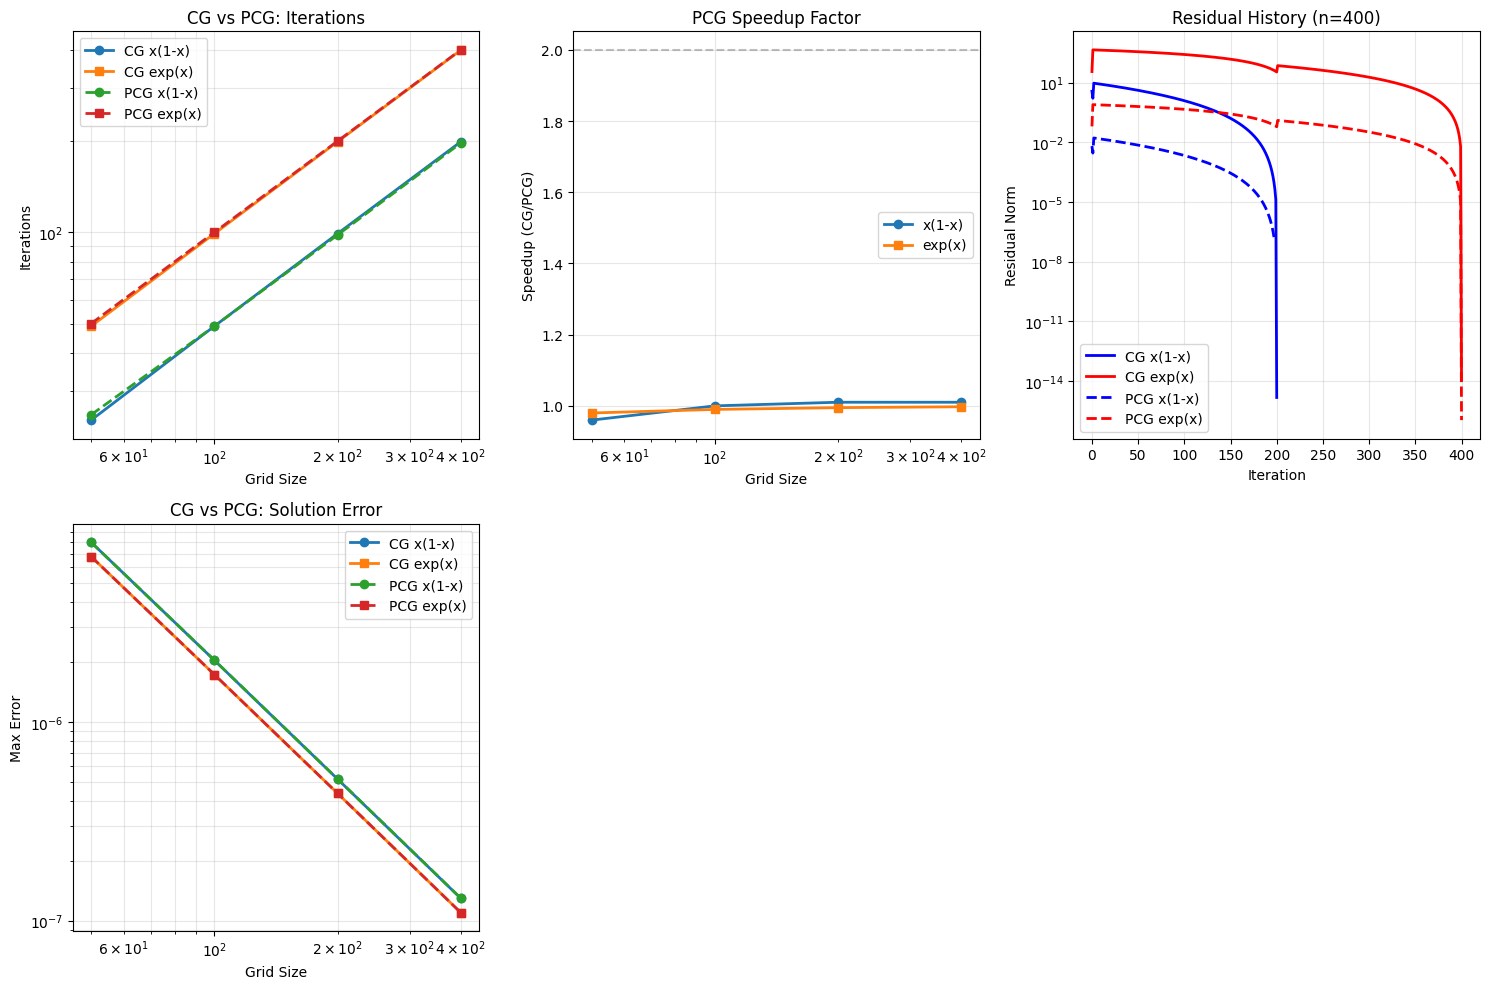


SUMMARY: CG vs PCG Comparison
Grid Size    Method   x(1-x) Iters    exp(x) Iters    x(1-x) Error    exp(x) Error   
--------------------------------------------------------------------------------
50           CG       24              49              8.01e-06        6.79e-06       
             PCG      25              50              8.01e-06        6.79e-06       
             Speedup  0.96            0.98           
--------------------------------------------------------------------------------
100          CG       49              99              2.04e-06        1.73e-06       
             PCG      49              100             2.04e-06        1.73e-06       
             Speedup  1.00            0.99           
--------------------------------------------------------------------------------
200          CG       99              199             5.16e-07        4.37e-07       
             PCG      98              200             5.17e-07        4.37e-07       
             Spe

In [ ]:
# Create separate lists for CG results
cg_iterations_x1x = []
cg_iterations_exp = []
cg_error_x1x = []
cg_error_exp = []
cg_residuals_x1x = []
cg_residuals_exp = []


# Now run both CG and PCG for comparison
grid_size = [50, 100, 200, 400] #intervals

# Storage for both methods
results = {
    'CG': {'x1x': {'iter': [], 'error': [], 'resid': []},
           'exp': {'iter': [], 'error': [], 'resid': []}},
    'PCG': {'x1x': {'iter': [], 'error': [], 'resid': []},
            'exp': {'iter': [], 'error': [], 'resid': []}}
}

for size in grid_size:
    print(f"\n{'='*60}")
    print(f"Grid Size: {size}")
    print('='*60)
    h = (1/(size+1))
    x = np.linspace(h,1-h, size)

    right_hand_side = {
        "x(1-x)": lambda x: x*(1-x),
        "exp(x)": lambda x: np.exp(x)
    }

    true_solutions = {
        "x(1-x)": -x**3/6 + x**4/12 + x/12,
        "exp(x)": -np.exp(x) + (np.e - 1)*x + 1
    }

    # Create the poisson matrix
    A = poisson_1d_matrix(size).to_csr()

    for func_name, func_value in right_hand_side.items():
        print(f"\n{func_name}:")
        b = build_rhs(size, func_value)
        u_exact = true_solutions[func_name]
        tol_aim = 0.01*h**2
        # Solve with CG (no preconditioner)
        u_cg, resid_cg, info_cg = conjugate_gradient(A, b, tol_aim)
        iter_cg = info_cg['iterations']
        error_cg = np.max(np.abs(u_cg - u_exact))

        # Solve with PCG (with preconditioner)
        u_pcg, resid_pcg, iter_pcg = pcg(A, b, tol_aim)
        error_pcg = np.max(np.abs(u_pcg - u_exact))

        # Store results
        if func_name == "x(1-x)":
            results['CG']['x1x']['iter'].append(iter_cg)
            results['CG']['x1x']['error'].append(error_cg)
            results['CG']['x1x']['resid'].append(resid_cg)

            results['PCG']['x1x']['iter'].append(iter_pcg)
            results['PCG']['x1x']['error'].append(error_pcg)
            results['PCG']['x1x']['resid'].append(resid_pcg)
        else:
            results['CG']['exp']['iter'].append(iter_cg)
            results['CG']['exp']['error'].append(error_cg)
            results['CG']['exp']['resid'].append(resid_cg)

            results['PCG']['exp']['iter'].append(iter_pcg)
            results['PCG']['exp']['error'].append(error_pcg)
            results['PCG']['exp']['resid'].append(resid_pcg)

        print(f"  CG  - Iterations: {iter_cg:4d}, Max error: {error_cg:.2e}")
        print(f"  PCG - Iterations: {iter_pcg:4d}, Max error: {error_pcg:.2e}")
        print(f"  Speedup: {iter_cg/iter_pcg:.2f}x")

# Plot comparison
plt.figure(figsize=(15, 10))

# Plot 1: Iterations comparison
plt.subplot(2, 3, 1)
plt.loglog(grid_size, results['CG']['x1x']['iter'], 'o-', label='CG x(1-x)', linewidth=2)
plt.loglog(grid_size, results['CG']['exp']['iter'], 's-', label='CG exp(x)', linewidth=2)
plt.loglog(grid_size, results['PCG']['x1x']['iter'], 'o--', label='PCG x(1-x)', linewidth=2)
plt.loglog(grid_size, results['PCG']['exp']['iter'], 's--', label='PCG exp(x)', linewidth=2)
plt.xlabel('Grid Size')
plt.ylabel('Iterations')
plt.title('CG vs PCG: Iterations')
plt.legend()
plt.grid(True, alpha=0.3, which='both')

# Plot 2: Speedup ratio
plt.subplot(2, 3, 2)
speedup_x1x = [results['CG']['x1x']['iter'][i]/results['PCG']['x1x']['iter'][i]
               for i in range(len(grid_size))]
speedup_exp = [results['CG']['exp']['iter'][i]/results['PCG']['exp']['iter'][i]
               for i in range(len(grid_size))]
plt.semilogx(grid_size, speedup_x1x, 'o-', label='x(1-x)', linewidth=2)
plt.semilogx(grid_size, speedup_exp, 's-', label='exp(x)', linewidth=2)
plt.xlabel('Grid Size')
plt.ylabel('Speedup (CG/PCG)')
plt.title('PCG Speedup Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=2, color='gray', linestyle='--', alpha=0.5)

# Plot 3: Residual history for largest grid
plt.subplot(2, 3, 3)
plt.semilogy(results['CG']['x1x']['resid'][-1], 'b-', label='CG x(1-x)', linewidth=2)
plt.semilogy(results['CG']['exp']['resid'][-1], 'r-', label='CG exp(x)', linewidth=2)
plt.semilogy(results['PCG']['x1x']['resid'][-1], 'b--', label='PCG x(1-x)', linewidth=2)
plt.semilogy(results['PCG']['exp']['resid'][-1], 'r--', label='PCG exp(x)', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title(f'Residual History (n={grid_size[-1]})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Error comparison
plt.subplot(2, 3, 4)
plt.loglog(grid_size, results['CG']['x1x']['error'], 'o-', label='CG x(1-x)', linewidth=2)
plt.loglog(grid_size, results['CG']['exp']['error'], 's-', label='CG exp(x)', linewidth=2)
plt.loglog(grid_size, results['PCG']['x1x']['error'], 'o--', label='PCG x(1-x)', linewidth=2)
plt.loglog(grid_size, results['PCG']['exp']['error'], 's--', label='PCG exp(x)', linewidth=2)
plt.xlabel('Grid Size')
plt.ylabel('Max Error')
plt.title('CG vs PCG: Solution Error')
plt.legend()
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY: CG vs PCG Comparison")
print("="*80)
print(f"{'Grid Size':<12} {'Method':<8} {'x(1-x) Iters':<15} {'exp(x) Iters':<15} {'x(1-x) Error':<15} {'exp(x) Error':<15}")
print("-"*80)

for i, size in enumerate(grid_size):
    print(f"{size:<12} {'CG':<8} {results['CG']['x1x']['iter'][i]:<15} {results['CG']['exp']['iter'][i]:<15} "
          f"{results['CG']['x1x']['error'][i]:<15.2e} {results['CG']['exp']['error'][i]:<15.2e}")
    print(f"{'':<12} {'PCG':<8} {results['PCG']['x1x']['iter'][i]:<15} {results['PCG']['exp']['iter'][i]:<15} "
          f"{results['PCG']['x1x']['error'][i]:<15.2e} {results['PCG']['exp']['error'][i]:<15.2e}")
    print(f"{'':<12} {'Speedup':<8} {results['CG']['x1x']['iter'][i]/results['PCG']['x1x']['iter'][i]:<15.2f} "
          f"{results['CG']['exp']['iter'][i]/results['PCG']['exp']['iter'][i]:<15.2f}")
    print("-"*80)

In [ ]:
"""
Summary of CG vs PCG (Jacobi)
For the 1D poisson equatio, we have a nearly diagonal matrix
Therefore, we see limited to no benefit of using the diagonal values (Jacobi)
as a preconditioner
"""

'\nSummary of CG vs PCG (Jacobi)\nFor the 1D poisson equatio, we have a nearly diagonal matrix\nTherefore, we see limited to no benefit of using the diagonal values (Jacobi)\nas a preconditioner\n'

In [ ]:
"""
1. Why second order convergence appears
* We obtain a second order difference approximation
for the equation -u_{xx}
* This comes from the forward difference and the Backwards difference
* We add them together to get the standard second order approximation
  Truncation error
  * When we find the truncation error, of the difference scheme
  after cancellations, the highest order error term that remains
  O(h^2). Truncation error = O(h^2).

  Discrete fourier transform for stability
  * plugging in the DFT into the sceme, and enforcing the
  stability condition that the amplification matrix must
  be <=1. we see that stability is ensured if and only if
  change in t divided by h^2 is <=1/2, for the explicit scheme

  Lax equivalence theorem
  * Since we have a well posed linear PDE, we can use the
  lax equicalence theorem, where consistency+stability = convergence
  * Thus the O(h^2) truncation error+stability = second-order
  convergence

2. Convergence of the conjugate gradient algorithm
* The A-norm of the current iteration divided by the A-norm of the base iteration
is less than or equal to 2*(sqrt(k)-1)/(sqrt(k)+1). Where K is the condition number.
Using the eigen values given by the formula Lambda = 2-2cos((J*pi)/(N+1)),
we can get the condition number p = lambda_max/lambda_min.
Thus the convergence rate is given p = (n-1)/(n+1), due to the condition number K = n^2.
If you double the grid points the condition number quadruples.
Number of iterations doubles. Total unknowns quadruples, and the the total work increases to 8n^3
a factor of 8 due to (2n)*(4n^2).


3. Tolerance error + Discretization error = Total error
*When solving PDEs with iterative methods, total error has two components:
- discretizing error: from approximating the PDE with finite differences O(h^2)
- Iteration error: from not solving the linear system exactly
- These errors should be balanced, there is no benefit in solving to tolerance
smaller than the discretization error.
- This avoids over-solving on coarse grids and undersolving on fine grids


"""

'\n1. Why second order convergence appears\n* We obtain a second order difference approximation\nfor the equation -u_{xx}\n* This comes from the forward difference\n* Backwards difference\n* Then we add them together to get the standard second order approximation\n  Truncation error\n  * When we find the truncation error, of the difference scheme\n  after cancellations, the highest order error term that remains\n  O(h^2). Truncation error = O(h^2).\n\n  Discrete fourier transform for stability\n  * plugging in the DFT into the sceme, and enforcing the\n  stability condition that the amplification matrix must\n  be <=1. we see that stability is ensured if and only if\n  change in t divided by h^2 is <=1/2, for the explicit scheme\n\n  Lax equivalence theorem\n  * Since we have a well posed linear PDE, we can use the\n  lax equicalence theorem, where consistency+stability = convergence\n  * Thus the O(h^2) truncation error+stability = second-order\n  convergence\n\n2. Convergence of the 